In [34]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import EstimatorV2, SamplerV2 as Estimator, Sampler 
from qiskit_ibm_runtime import QiskitRuntimeService

### Mapping classical inputs to a quantum problem

In [44]:
# Single trail of the probabilistic gates
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

circuit = QuantumCircuit(controls, target, mid_measure, final_measure)

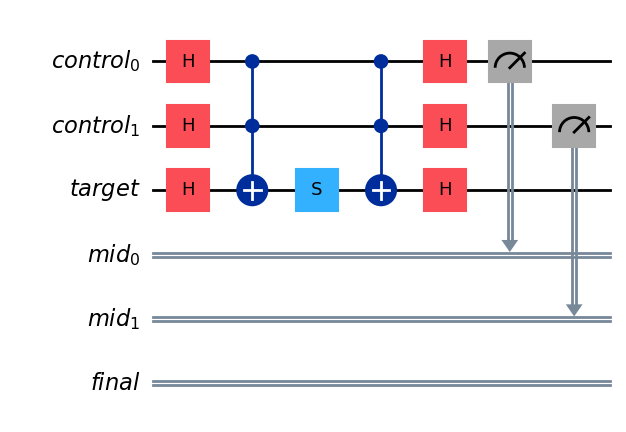

In [45]:
# Probabilistic Rx gate(para), para := r'*pi, r' is not rational
def trial(circuit, target, controls, measures): 
    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls, measures)
    
trial(circuit, target, controls, mid_measure)
circuit.draw(output="mpl", style="iqp", cregbundle=False)

In [46]:
# Success := |0>, P_success = 5/8; Failure := |1>, P_failure = 3/8
# reset_controls if failure == True
def reset_controls(circuit, controls, measures):
    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])

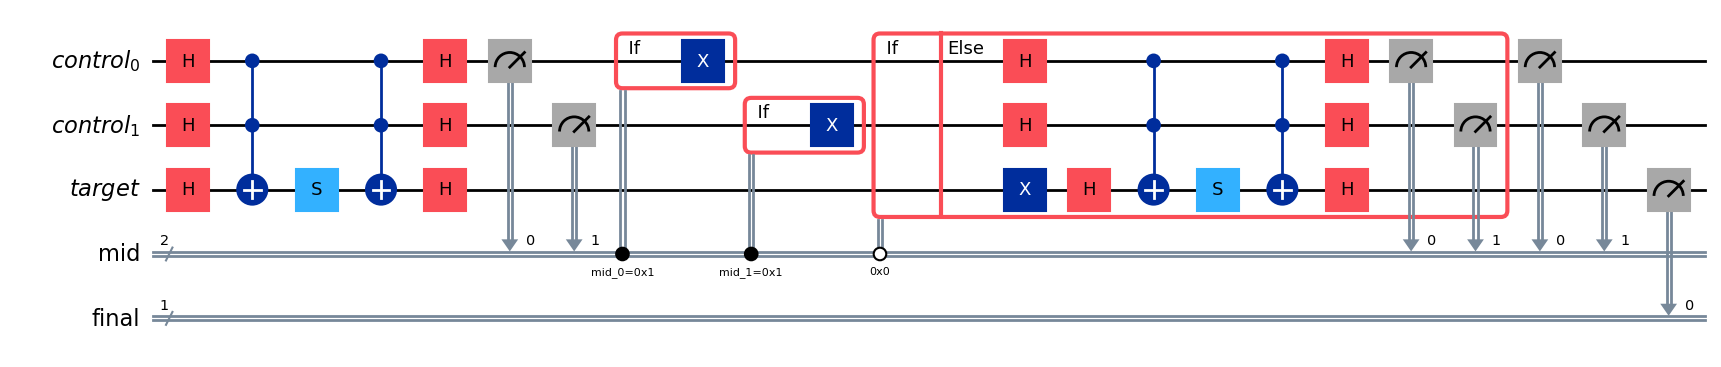

In [47]:
max_trials = 2
for _ in range(max_trials - 1): 
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_: 
        pass
    with else_:
        # Reset the target and repeat the trial because Failure == True
        circuit.x(target)
        trial(circuit, target, controls, mid_measure)
        
circuit.measure(controls, mid_measure)
circuit.measure(target, final_measure)
    
circuit.draw(output="mpl", style="iqp", cregbundle=True)

### Optimization for quantum execution

In [13]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(f">>> Connected to {backend.name} backend.")

>>> Connected to ibm_sherbrooke backend.


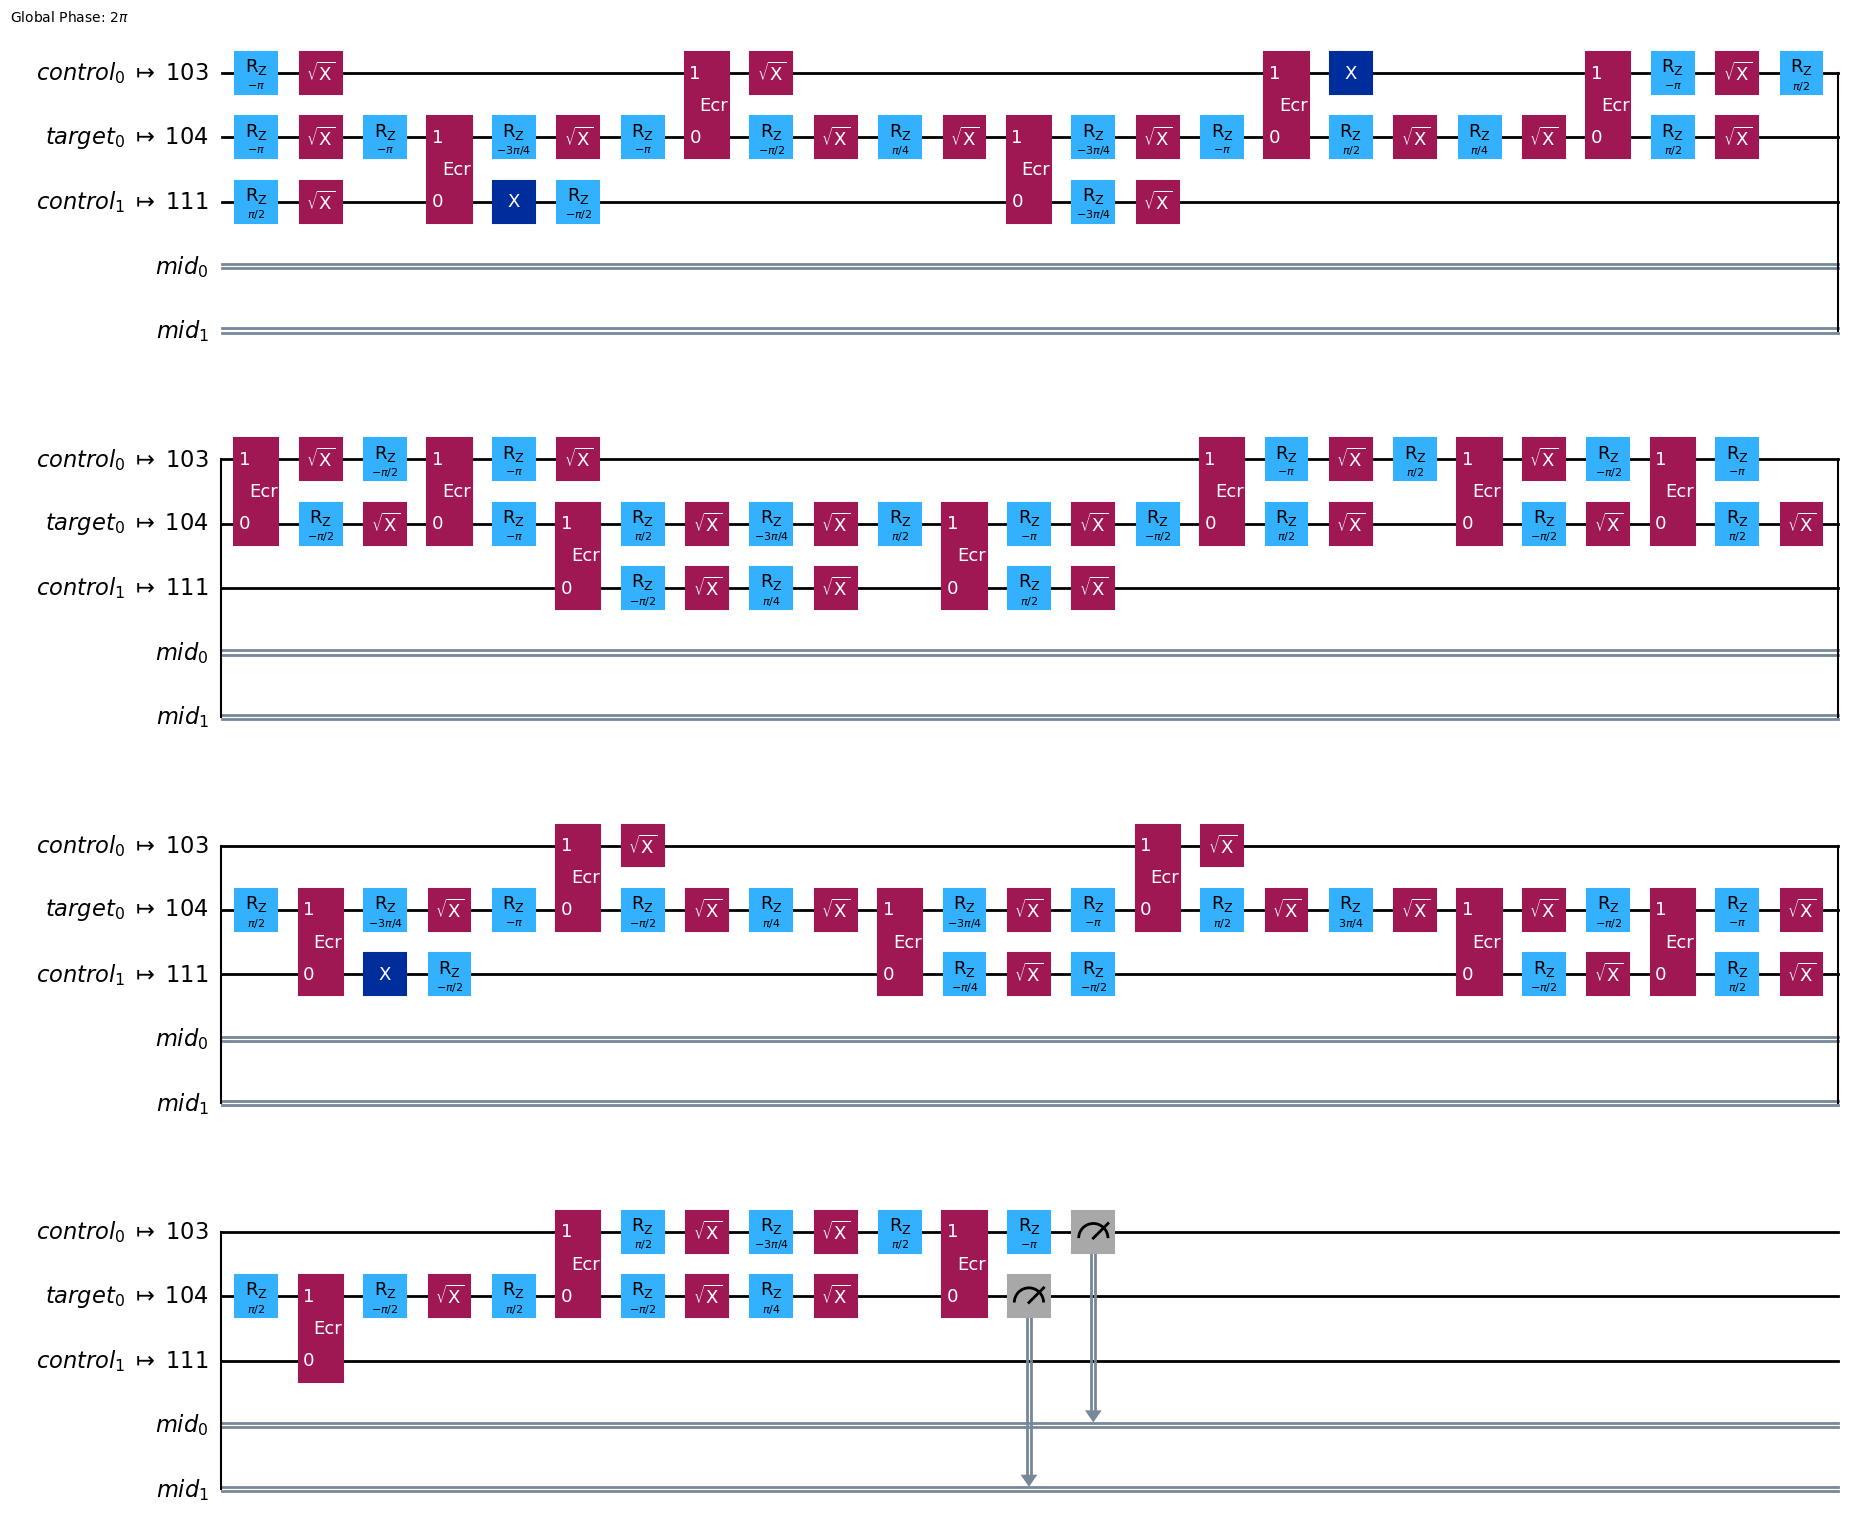

In [28]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw(output="mpl", style="iqp", idle_wires=False, cregbundle=False)

### Quantum execution

In [35]:
sampler = Sampler(backend)
job = sampler.run([(isa_circuit)])
job.job_id()

'cvn51zqqwj7g008y57zg'

In [48]:
hardware_counts = job.result()[0]

data_mid = job.result()[0].data.mid
data_final = job.result()[0].data.final

print(f">>> Hardware counts for mid: {data_mid.get_counts()}")
print(f">>> Hardware counts for final: {data_final.get_counts()}")

>>> Hardware counts for mid: {'11': 832, '01': 948, '00': 1504, '10': 812}
>>> Hardware counts for final: {'0': 4096}


In [49]:
from collections import defaultdict

merged_data = defaultdict(int)
for bs1, bs2 in zip(data_mid.get_bitstrings(), data_final.get_bitstrings()): 
    merged_data[f"{bs1}-{bs2}"] += 1
    
print(f">>> Hardware merged data: {dict(merged_data)}")

>>> Hardware merged data: {'11-0': 832, '01-0': 948, '00-0': 1504, '10-0': 812}


### Post-processing

In [50]:
def marginalize_successes(counts):
    successes = defaultdict(int)
    failures = defaultdict(int)
    
    for key, value in counts.items():
        if key.startswith("00"):
            successes[key[-1]] += value
        else: 
            failures[key[-1]] += value
            
    return successes, failures

In [51]:
hw_successes, hw_failures = marginalize_successes(merged_data)

expected_successes = 1 - (1 - 5/8)**max_trials
actual_successes = sum(hw_successes.values()) / sum(merged_data.values())
print(f"Expected success rate: {expected_successes:5.3f}.")
print(f"Actual success rate: {actual_successes:5.3f}")

Expected success rate: 0.859.
Actual success rate: 0.367
